## TOC:
* [Setup](#first-bullet)
* [Introduction](#second-bullet)
* [Binary Segmentation - U-Net](#third-bullet)
* [Multi-class Segmentation - DeepLabV3](#forth-bullet)
* [Instance Segmentation - Mask R-CNN](#fifth-bullet)
* [Semantic Segmentation - FCN, Segformer](#sixth-bullet)
* [Panoptic Segmentation - Detectron 2](#seventh-bullet)
* [Image Segmentation: Dataset Types, Metrics, and Learning Tasks](#eigth-bullet)
* [TLDR](#last-bullet)

## Setup <a class="anchor" id="first-bullet"></a>

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


## 0. Introduction <a class="anchor" id="second-bullet"></a>

Image segmentation is the task of partitioning an image into meaningful regions, \
often to identify and locate specific objects or areas of interest within the image. \
In this notebook, we explore segmentation types, methods, and models using the Mapillary Vistas Dataset, \
which offers high-quality labeled images of various urban scenes.


### Segmentation Types
1. **Binary Segmentation**: Differentiates an object of interest from the background.
2. **Multiclass Segmentation**: Identifies multiple distinct classes in an image.
3. **Instance Segmentation**: Labels individual instances of objects within classes.
4. **Semantic Segmentation**: Assigns a class label to every pixel.
5. **Panoptic Segmentation**: Combines instance and semantic segmentation, distinguishing objects as unique entities while labeling amorphous areas.

### Real-Life Applications
1. **Autonomous Driving**: Identifying road elements and obstacles.
2. **Medical Imaging**: Segmenting tumors and organs.
3. **Satellite Imagery**: Classifying land types.
4. **Augmented Reality**: Overlaying virtual objects on real environments.

---
## 1. Binary Segmentation - U-Net <a class="anchor" id="third-bullet"></a>

### Concept Explanation
Binary segmentation involves partitioning an image into two classes: the object of interest and the background. It is often used when only one type of object is of interest.

### Mathematical Foundations
Binary segmentation can be treated as a pixel-wise binary classification task, where we minimize binary cross-entropy (BCE) loss:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)
$$


In [4]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights
from torchvision.models.segmentation import deeplabv3_resnet101

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import json

In [3]:
class ResizeTransform:
    def __init__(self, size):
        self.size = size
        self.image_transform = transforms.Resize(size, transforms.InterpolationMode.BILINEAR)
        self.mask_transform = transforms.Resize(size, transforms.InterpolationMode.NEAREST)

    def __call__(self, image, mask):
        image = self.image_transform(image)  # Smooth resizing for the image
        mask = self.mask_transform(mask)    # Nearest-neighbor resizing for the mask
        return image, mask

In [4]:
class MapillaryVistasLoader(Dataset):
    def __init__(self, root, split="training", img_size=(1025, 2049), is_transform=True, augmentations=None, test_mode=False, max_samples=None):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.ignore_id = 250
        self.max_samples = max_samples  # Set maximum number of samples

        # File paths and image loading
        if not test_mode:
            self.images_base = os.path.join(self.root, self.split, "images")
            self.annotations_base = os.path.join(self.root, self.split, "labels")
            self.files = recursive_glob(rootdir=self.images_base, suffix=".jpg")
            
            # Limit the number of files if max_samples is set
            if self.max_samples:
                self.files = self.files[:self.max_samples]

            if not self.files:
                raise FileNotFoundError(f"No files for split=[{split}] found in {self.images_base}")
            print(f"Found {len(self.files)} {split} images (limited to max_samples={self.max_samples})" if self.max_samples else f"Found {len(self.files)} {split} images")
        
        # Load label information
        self.class_names, self.class_colors, self.label_mapping = self.parse_config(os.path.join(self.root, "config.json"))
        self.num_classes = len(self.class_names)

    def parse_config(self, config_path):
        with open(config_path) as config_file:
            config = json.load(config_file)
        
        labels = config["labels"]
        class_names = []
        class_colors = []
        label_mapping = {}

        for index, label in enumerate(labels):
            if label["evaluate"]:
                label_mapping[index] = len(class_names)  # Map to continuous ID
                class_names.append(label["readable"])
                class_colors.append(label["color"])
            else:
                label_mapping[index] = self.ignore_id  # Ignore label
        
        return class_names, class_colors, label_mapping

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = self.files[index].rstrip()
        lbl_path = os.path.join(self.annotations_base, os.path.basename(img_path).replace(".jpg", ".png"))

        img = np.array(Image.open(img_path).convert("RGB"))
        lbl = np.array(Image.open(lbl_path).convert("L"))

        # Apply augmentations (both image and mask)
        if self.augmentations is not None:
            augmented = self.augmentations(image=img, mask=lbl)
            img = augmented['image']
            lbl = augmented['mask']

        # Resize and transform
        if self.is_transform:
            img, lbl = self.transform(img, lbl)

        
        # Debug: Check that label values are within bounds
        if (torch.max(lbl) >= self.num_classes and torch.max(lbl) != self.ignore_id) or (torch.min(lbl) < 0 and torch.min(lbl) != self.ignore_id):
            raise ValueError(f"Label values out of bounds: min {torch.min(lbl)}, max {torch.max(lbl)}")

        return img, lbl

    def transform(self, img, lbl):
        # Ensure img is a NumPy array for resizing and processing
        if isinstance(img, torch.Tensor):
            img = img.numpy().transpose(1, 2, 0)  # Convert CHW to HWC if img is a Tensor
        if isinstance(lbl, torch.Tensor):
            lbl = lbl.numpy()

        # Resize image and label to target size
        if self.img_size != ("same", "same"):
            img = Image.fromarray((img * 255).astype(np.uint8)).resize((self.img_size[1], self.img_size[0]), resample=Image.LANCZOS)
            lbl = Image.fromarray(lbl).resize((self.img_size[1], self.img_size[0]), resample=Image.NEAREST)

        # Convert image back to NumPy, normalize, and then to tensor
        img = np.array(img).astype(np.float32) / 255.0
        img = torch.from_numpy(img.transpose(2, 0, 1)).float()  # HWC to CHW

        # Apply label encoding and convert label to tensor
        lbl = np.array(lbl, dtype=np.int32)
        
        lbl[lbl == self.ignore_id] = 65
        lbl = self.encode_segmap(lbl)
        # lbl[lbl == 0] = self.ignore_id

        lbl = torch.from_numpy(lbl).long()
        
        return img, lbl

    def encode_segmap(self, mask):
        """Map original mask labels to a continuous range."""
        mapped_mask = np.full_like(mask, self.ignore_id)
        for orig_label, new_label in self.label_mapping.items():
            mapped_mask[mask == orig_label] = new_label
        return mapped_mask

    def decode_segmap(self, mask):
        """Decode segmentation map to RGB colors for visualization."""
        rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for label_id, color in enumerate(self.class_colors):
            rgb_mask[mask == label_id] = color
        return rgb_mask

In [ ]:


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dir = r"..\data\New folder\v2\training\v1.2\instances"
ds_masks_dir = r"..\data\New folder\v2\training\v1.2\labels"
json_config = r"..\data\New folder\v2\config_v1.2.json"

# Create dataset and dataloader
# train_dataset = MapillaryDataset(
#     images_dir=train_dir,
#     masks_dir=ds_masks_dir,
#     config_path=json_config,
#     transform=transform,
#     target_size=(512, 1024)
# )

# Define augmentations using torchvision
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=6, p=0.5),
    ToTensorV2()
])

def recursive_glob(rootdir=".", suffix=""):
    """Recursively finds all files with the given suffix."""
    return [
        os.path.join(root, filename)
        for root, _, files in os.walk(rootdir)
        for filename in files
        if filename.endswith(suffix)
    ]

local_path = r"..\data\New folder\v1"
train_dataset = MapillaryVistasLoader(
    root=local_path,
    split='training',
    img_size=(512, 1024),
    is_transform=True,
    augmentations=augment,
    max_samples=256  # Limit to 10 images
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Found 256 training images (limited to max_samples=256)


In [13]:
# Initialize U-Net model
num_classes = 65  # Mapillary Vistas has 65 classes for semantic segmentation
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=num_classes)

# device = torch.device("cpu")
# model = model.to(device)

In [14]:
# for name, param in model.named_parameters():
#     print(f"Parameter {name} is on device: {param.device}")

In [15]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
ignore_id = 250 
criterion = torch.nn.CrossEntropyLoss(ignore_index=ignore_id)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
# for images, masks in train_loader:
#     unique_labels = torch.unique(masks)
#     print("Unique labels in mask:", unique_labels)
#     break

In [17]:
num_epochs = 5
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        print("Output shape:", outputs.shape)
        loss = criterion(outputs, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Epoch [1/5], Loss: 2.4539
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output shape: torch.Size([16, 65, 512, 1024])
Output s

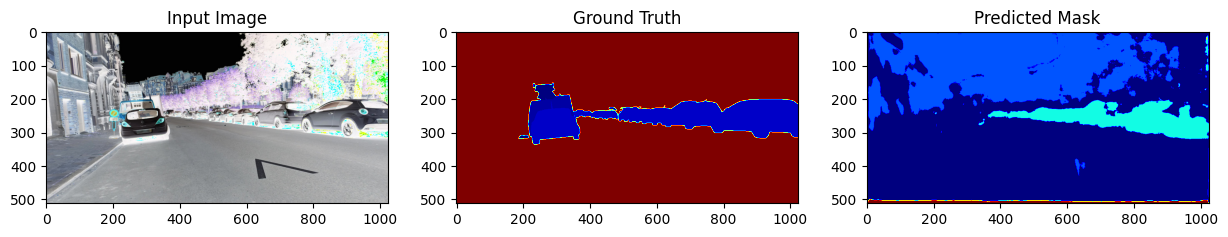

In [22]:
model.eval()
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # Convert output to class predictions
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        # Visualize one sample
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images[0].cpu().permute(1, 2, 0))
        ax[0].set_title("Input Image")
        ax[1].imshow(masks[0].cpu(), cmap="jet")
        ax[1].set_title("Ground Truth")
        ax[2].imshow(preds[0], cmap="jet")
        ax[2].set_title("Predicted Mask")
        plt.show()
        
        break

## 2. Multi-class Segmentation - DeepLabV3 <a class="anchor" id="forth-bullet"></a>

Multiclass segmentation assigns each pixel to one of several possible classes. \
It is useful for tasks where multiple distinct classes are present, such as urban scenes with roads, buildings, and pedestrians.

Mathematical Foundations
Multiclass segmentation uses categorical cross-entropy loss for each pixel:

The formula for Categorical Cross-Entropy Loss is:

$$
\text{Categorical Cross-Entropy Loss} = - \sum_{c=1}^{C} y_{ic} \cdot \log(\hat{y}_{ic})
$$

#### Explanation of Terms

- $ C $: The total number of classes.
- $ y_{ic} $: The true label indicator (binary) for class $ c $ for sample $ i $. $ y_{ic} = 1 $ if the true class of sample $ i $ is $ c $, and $ y_{ic} = 0 $ otherwise.
- $ \hat{y}_{ic} $: The predicted probability of class $ c $ for sample $ i $ (the output of the softmax function for that class).

#### Description

- This loss function computes the negative log of the probability assigned to the true class, averaged (or summed) across all samples.
- For a single sample $ i $, this loss penalizes the model for assigning a lower probability to the correct class, encouraging the model to increase the probability of the correct class in future iterations.
- **Interpretation**: The closer $ \hat{y}_{ic} $ is to $ y_{ic} $, the lower the loss. Minimizing this loss function leads the model to provide high probabilities for the correct classes.

#### Usage in Machine Learning

This loss is commonly used in multi-class classification tasks where each sample belongs to one of $ C $ possible classes. It’s often used with the softmax activation function on the model's output layer, as the softmax function converts raw scores into probability distributions across classes.


 -- Fixed Object -- 
 -- Animal -- 
 -- Fence -- 
 -- Caravan -- 
 -- Bicyclist -- 


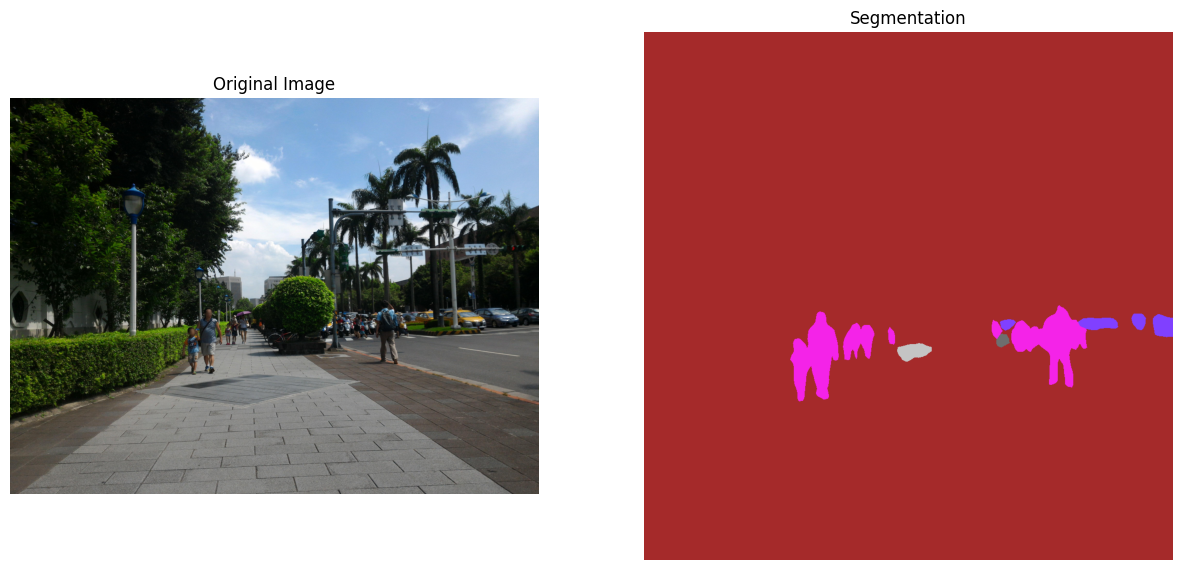

In [ ]:


# Load pre-trained DeepLabV3 model
# model = deeplabv3_resnet101(pretrained=True)  # Replace with custom weights if available
model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)  

model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize(1024),  # Resize to Mapillary Vistas image size
    transforms.CenterCrop(1024),  # Adjust as per your needs
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define Mapillary Vistas color palette for 66 classes (simplified)
# Full color mapping is available in the Mapillary Vistas config file
# Each entry corresponds to an RGB color for each class
mapillary_colors = np.array([
    [165, 42, 42],    # Class 0: Animal
    [0, 192, 0],      # Class 1: Archway
    [196, 196, 196],  # Class 2: Bicyclist
    [190, 153, 153],  # Class 3: Bridge
    [180, 165, 180],  # Class 4: Building Other
    [90, 120, 150],   # Class 5: Bus
    [102, 102, 156],  # Class 6: Car
    [128, 64, 255],   # Class 7: Caravan
    [140, 140, 200],  # Class 8: CartLuggagePram
    [170, 170, 170],  # Class 9: Child Area
    [250, 170, 160],  # Class 10: Curb Cut
    [96, 96, 96],     # Class 11: Cycle Lane
    [230, 150, 140],  # Class 12: Driveway
    [128, 64, 128],   # Class 13: Emergency Vehicle
    [110, 110, 110],  # Class 14: Fence
    [244, 35, 232],   # Class 15: Fixed Object
    [150, 100, 100],  # Class 16: Flat Other
    [70, 70, 70],     # Class 17: Gated Object
    [150, 120, 90],   # Class 18: Guard Rail
    [220, 20, 60],    # Class 19: Motorcycle
    [180, 130, 70],   # Class 20: Obstacle
    [102, 102, 102],  # Class 21: Object Marker
    [60, 20, 220],    # Class 22: On Rails
    [0, 0, 100],      # Class 23: Parking
    [255, 30, 30],    # Class 24: Paved Area
    [245, 150, 100],  # Class 25: Pedestrian Area
    [255, 0, 0],      # Class 26: Pedestrian Crossing
    [100, 150, 255],  # Class 27: Post
    [250, 170, 30],   # Class 28: Ramp Area
    [220, 220, 220],  # Class 29: Road
    [155, 155, 155],  # Class 30: Road Marking
    [0, 60, 100],     # Class 31: Signal Light
    [120, 10, 10],    # Class 32: Sign Symbol
    [0, 0, 90],       # Class 33: Sky
    [0, 0, 110],      # Class 34: Street Furniture
    [10, 80, 20],     # Class 35: Street Sign
    [20, 0, 200],     # Class 36: Temporary Structure
    [0, 0, 255],      # Class 37: Terrain Other
    [153, 153, 153],  # Class 38: Traffic Island
    [70, 130, 180],   # Class 39: Traffic Light
    [250, 0, 30],     # Class 40: Trailer
    [100, 140, 180],  # Class 41: Train
    [220, 20, 220],   # Class 42: Tree
    [240, 50, 230],   # Class 43: Truck
    [220, 200, 50],   # Class 44: Tunnel
    [180, 220, 20],   # Class 45: Vegetation
    [120, 60, 60],    # Class 46: Vegetation Barrier
    [150, 100, 100],  # Class 47: Wall
    [30, 30, 255],    # Class 48: Water
    [200, 100, 150],  # Class 49: Window
    [0, 255, 255],    # Class 50: Bicycle
    [255, 100, 100],  # Class 51: Person
    [255, 255, 0],    # Class 52: Pole
    [150, 255, 255],  # Class 53: Railing
    [255, 100, 0],    # Class 54: Road Arrow
    [153, 153, 255],  # Class 55: Road Divider
    [153, 153, 0],    # Class 56: Tree Trunk
    [153, 0, 0],      # Class 57: Traffic Sign
    [153, 0, 153],    # Class 58: Underside of Road
    [153, 0, 204],    # Class 59: Wall Barrier
    [153, 0, 255],    # Class 60: Road Divider Other
    [153, 0, 102],    # Class 61: Vehicle Barrier
    [128, 64, 255],   # Class 62: Vertical Marking
    [0, 204, 102],    # Class 63: Water Area
    [255, 153, 204],  # Class 64: Window Other
    [128, 128, 128],  # Class 65: Other
])

mapillary_classes = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building Other', 'Bus', 'Car', 'Caravan', 'CartLuggagePram', 'Child Area', 'Curb Cut', 'Cycle Lane', 'Driveway', 
                     'Emergency Vehicle', 'Fence', 'Fixed Object', 'Flat Other', 'Gated Object', 'Guard Rail', 'Motorcycle', 'Obstacle', 'Object Marker', 'On Rails', 'Parking', 
                     'Paved Area', 'Pedestrian Area', 'Pedestrian Crossing', 'Post', 'Ramp Area', 'Road', 'Road Marking', 'Signal Light', 'Sign Symbol', 'Sky', 'Street Furniture', 
                     'Street Sign', 'Temporary Structure', 'Terrain Other', 'Traffic Island', 'Traffic Light', 'Trailer', 'Train', 'Tree', 'Truck', 'Tunnel', 'Vegetation', 
                     'Vegetation Barrier', 'Wall', 'Water', 'Window', 'Bicycle', 'Person', 'Pole', 'Railing', 'Road Arrow', 'Road Divider', 'Tree Trunk', 'Traffic Sign', 
                     'Underside of Road', 'Wall Barrier', 'Road Divider Other', 'Vehicle Barrier', 'Vertical Marking', 'Water Area', 'Window Other', 'Other']


# Load an image from Mapillary Vistas dataset
image_path = r'..\data\New folder\v1\testing\images\___QXeb8e952hTD6EaQVEQ.jpg'
image_path = r'..\data\New folder\v2\testing\images\_dPhCIfN9ZyKIeTzK051SA.jpg'
image = Image.open(image_path).convert('RGB')
input_image = transform(image).unsqueeze(0)

# Perform segmentation
with torch.no_grad():
    output = model(input_image)['out'][0]  # get output tensor

# Generate the segmentation mask
output_predictions = output.argmax(0).byte().cpu().numpy()

# Map each pixel to the corresponding class color
segmentation_image = np.zeros((output_predictions.shape[0], output_predictions.shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(mapillary_colors):
    segmentation_image[output_predictions == class_id] = color

print()
# for label_color in np.unique(segmentation_image):

height, width, channels = segmentation_image.shape
predicted_labels = set()

for i in range(height):
    for j in range(width):
        pixel_val = segmentation_image[i, j]
        predicted_labels.add( (mapillary_classes[np.where(mapillary_colors == pixel_val)[0][0]], tuple(pixel_val.tolist())) )

for x in predicted_labels:
    class_name, class_rgb = x
    print(f'\033[38;2;{class_rgb[0]};{class_rgb[1]};{class_rgb[2]}m -- {class_name} -- \033[0m')

# Display original and segmentation result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(segmentation_image)
ax2.set_title("Segmentation")
ax2.axis("off")

plt.show()

## 3. Instance Segmentation - Mask R-CNN <a class="anchor" id="fifth-bullet"></a>

Instance segmentation assigns each pixel to a class label and a unique instance ID, \
distinguishing between individual objects within the same class. It is often used for applications where object separation is important.

Neural Network Architecture
Mask R-CNN is widely used for instance segmentation. It combines a region proposal network (RPN) with a segmentation branch to generate masks for each instance.

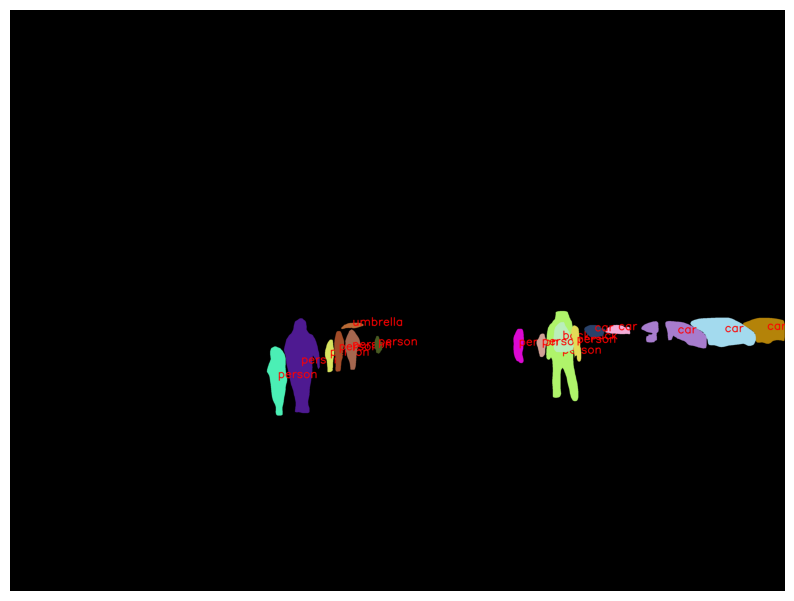

In [ ]:
import cv2
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog

# Configure Mask R-CNN model using Detectron2's model zoo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for detection
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained COCO weights

# Create predictor
predictor = DefaultPredictor(cfg)

# Load image
image = cv2.imread(r'..\data\New folder\v2\testing\images\_dPhCIfN9ZyKIeTzK051SA.jpg')
outputs = predictor(image)

# Extract masks and labels
masks = outputs["instances"].pred_masks.cpu().numpy()
labels = outputs["instances"].pred_classes.cpu().numpy()

# Create an empty canvas for displaying only the masks
mask_canvas = np.zeros((masks.shape[1], masks.shape[2], 3), dtype=np.uint8)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# Assign a random color to each mask and add label text
for i, mask in enumerate(masks):
    color = [random.randint(0, 255) for _ in range(3)]
    mask_canvas[mask] = color  # Apply color to the mask area

    # Get label text
    label_text = metadata.thing_classes[labels[i]]

    # Find mask centroid to place label text
    mask_indices = np.argwhere(mask)
    y_center, x_center = mask_indices.mean(axis=0).astype(int)

    # Place label text on mask with larger font size and thickness
    font_scale = 2  # Increase font scale for larger text
    thickness = 4     # Increase thickness for more prominent text
    cv2.putText(mask_canvas, label_text, (x_center, y_center), cv2.FONT_HERSHEY_SIMPLEX,
                font_scale, (255, 0, 0), thickness, cv2.LINE_AA)

# Display the masks with labels
plt.figure(figsize=(10, 10))
plt.imshow(mask_canvas)
plt.axis("off")
plt.show()

## 4. Semantic Segmentation - FCN, Segformer <a class="anchor" id="sixth-bullet"></a>

Semantic segmentation assigns a class label to every pixel, grouping all instances of the same class under one label. \
This type of segmentation is useful in applications where instance separation is not necessary.

Neural Network Architecture
Fully Convolutional Networks (FCN) replace fully connected layers with convolutional layers, making pixel-level predictions for semantic segmentation.

e:\ProgramingTools\anaconda_gus\envs\conda_fii_cv_3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to C:\Users\Gus/.cache\torch\hub\checkpoints\fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:02<00:00, 104MB/s]  


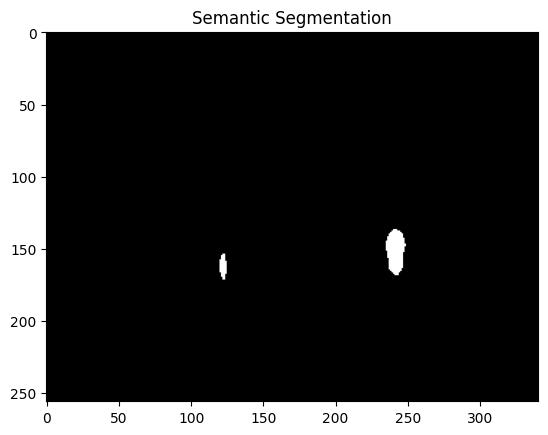

In [33]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# Load a pretrained FCN model
model = torchvision.models.segmentation.fcn_resnet101(pretrained=True).eval()

# Preprocess the image
input_image = Image.open(r'..\data\New folder\v2\testing\images\_dPhCIfN9ZyKIeTzK051SA.jpg')
preprocess = T.Compose([T.Resize(256), T.ToTensor()])
input_tensor = preprocess(input_image).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0)

# Display result
plt.imshow(output_predictions.numpy(), cmap='gray')
plt.title('Semantic Segmentation')
plt.show()

SegFormer
* Description: A newer model that utilizes transformers for segmentation tasks, achieving state-of-the-art results on benchmarks like ADE20K.
* Implementation: Available in libraries like transformers and mmsegmentation.

e:\ProgramingTools\anaconda_gus\envs\conda_fii_cv_3\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Gus\.cache\huggingface\hub\models--nvidia--segformer-b5-finetuned-ade-640-640. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


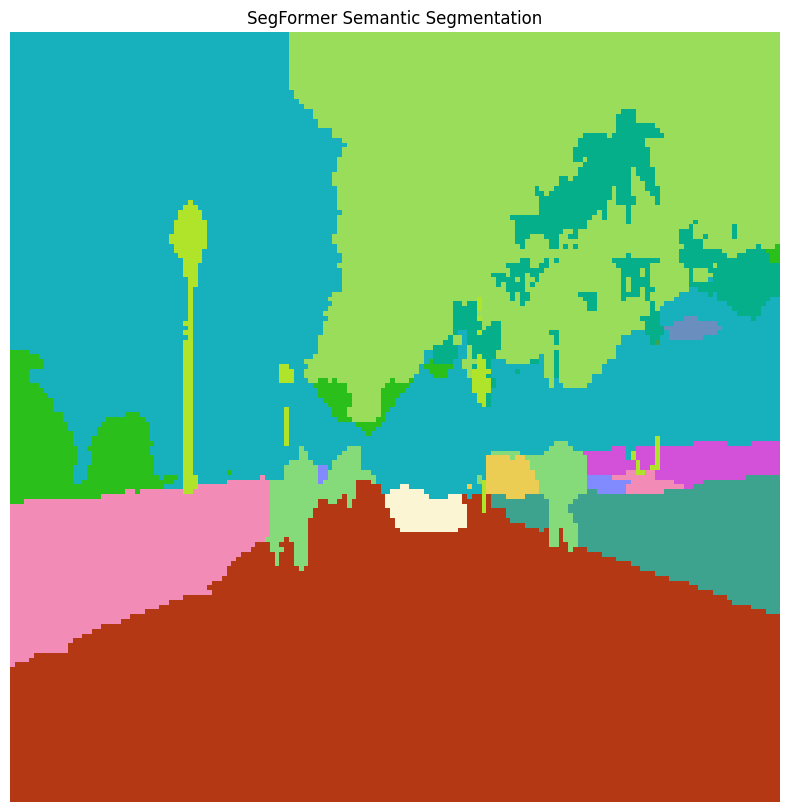

In [37]:
import torch
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load a pretrained SegFormer model and feature extractor
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"  # Choose model size, e.g., B0, B1, B2, B3, B4, B5
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"

feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# Load and preprocess the image
image = Image.open(r'..\data\New folder\v2\testing\images\_dPhCIfN9ZyKIeTzK051SA.jpg')  # Replace with your image path
inputs = feature_extractor(images=image, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: [batch_size, num_classes, height, width]

# Post-process the logits to get the predicted segmentation map
segmentation = logits.argmax(dim=1)[0]  # Take argmax over the class dimension
segmentation = segmentation.cpu().numpy()

# Define a color palette (optional, for visualization)
# Here we define colors for 150 classes in ADE20K (feel free to customize or add colors)
colors = np.random.randint(0, 255, (150, 3), dtype=np.uint8)
segmentation_color = colors[segmentation]

# Display the segmentation result
plt.figure(figsize=(10, 10))
plt.imshow(segmentation_color)
plt.axis("off")
plt.title("SegFormer Semantic Segmentation")
plt.show()

## 5. Panoptic Segmentation - Detectron 2 <a class="anchor" id="seventh-bullet"></a>

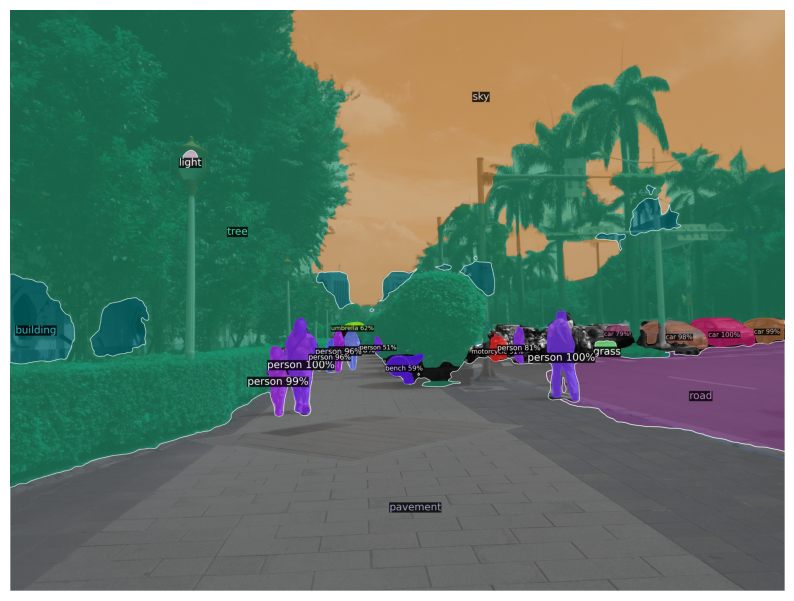

In [41]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# Set up configuration for Panoptic Segmentation using the model zoo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold for object detection

# Initialize predictor
predictor = DefaultPredictor(cfg)

# Load the image
im = cv2.imread(r'..\data\New folder\v2\testing\images\_dPhCIfN9ZyKIeTzK051SA.jpg')

# Perform prediction
outputs = predictor(im)

# Extract the panoptic segmentation results
panoptic_seg, segments_info = outputs["panoptic_seg"]

# Visualize the panoptic segmentation results
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE_BW)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

# Display the output
plt.figure(figsize=(10, 10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

# 6. Image Segmentation: Dataset Types, Metrics, and Learning Tasks <a class="anchor" id="eigth-bullet"></a>

## 1. Types of Segmentation Datasets

### 1.1 Binary Segmentation
- **Content**: Each pixel is classified as either part of the foreground (class `1`) or background (class `0`).
- **Examples**:
  - **ISBI 2012**: Cell nuclei segmentation.
  - **DRIVE**: Retinal vessel segmentation.
  - **LIDC-IDRI**: Lung tumor segmentation.
- **Metrics**:
  - Dice Coefficient (F1 score for pixels)
  - Intersection over Union (IoU)
  - Precision, Recall

---

### 1.2 Multiclass Segmentation
- **Content**: Each pixel belongs to one of multiple predefined classes.
- **Examples**:
  - **Pascal VOC**: Road, car, pedestrian segmentation.
  - **ADE20K**: Scene parsing (e.g., walls, sky, furniture).
  - **CamVid**: Semantic segmentation for driving scenes.
- **Metrics**:
  - Per-class IoU
  - Mean IoU (mIoU)
  - Pixel Accuracy
  - Mean Accuracy

---

### 1.3 Instance Segmentation
- **Content**: Each object instance (not just class) is segmented. Overlapping objects of the same class are treated as separate instances.
- **Examples**:
  - **COCO**: Common Objects in Context.
  - **Mapillary Vistas**: Vehicles, pedestrians, etc.
  - **LVIS**: Long-tail instance segmentation.
- **Metrics**:
  - Average Precision (AP) at IoU thresholds (e.g., `AP50`, `AP75`).
  - Mean Average Precision (mAP).

---

### 1.4 Panoptic Segmentation
- **Content**: Combines semantic and instance segmentation. Every pixel is labeled with either a semantic class or an instance ID.
- **Examples**:
  - **COCO Panoptic**: Combines COCO’s semantic and instance segmentation annotations.
  - **Cityscapes Panoptic**: Annotated urban scenes.
  - **Mapillary Vistas**: Street scenes with panoptic segmentation labels.
- **Metrics**:
  - Panoptic Quality (PQ)
  - Segmentation Quality (SQ)
  - Recognition Quality (RQ)

---

### 1.5 Semantic Segmentation
- **Content**: Each pixel belongs to a class, without distinguishing between different instances.
- **Examples**:
  - **Cityscapes**: Urban street scenes.
  - **ADE20K**: Large-scale scene parsing dataset.
  - **SUN RGB-D**: Indoor segmentation dataset.
- **Metrics**:
  - IoU
  - Mean IoU (mIoU)
  - Pixel Accuracy
  - Boundary IoU (for edge precision)

---

## 2. Metrics for Image Segmentation

### 2.1 Pixel Accuracy
The fraction of correctly classified pixels:
$$
\text{Pixel Accuracy} = \frac{\text{Number of Correct Pixels}}{\text{Total Number of Pixels}}
$$

---

### 2.2 Intersection over Union (IoU)
The ratio of the intersection to the union of the predicted and ground truth masks for a given class:
$$
\text{IoU} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)} + \text{False Negatives (FN)}}
$$

**Mean IoU (mIoU)**: The average IoU across all classes:
$$
\text{mIoU} = \frac{1}{C} \sum_{i=1}^{C} \text{IoU}_i
$$
Where $ C $ is the total number of classes.

---

### 2.3 Dice Coefficient (F1 Score for Pixels)
A measure of overlap between predicted and ground truth masks:
$$
\text{Dice} = \frac{2 \times |\text{Predicted} \cap \text{Ground Truth}|}{|\text{Predicted}| + |\text{Ground Truth}|}
$$

Alternatively:
$$
\text{Dice} = \frac{2 \times \text{True Positives (TP)}}{2 \times \text{True Positives (TP)} + \text{False Positives (FP)} + \text{False Negatives (FN)}}
$$

---

### 2.4 Panoptic Quality (PQ)
For panoptic segmentation, combining semantic and instance metrics:
$$
\text{PQ} = \frac{\sum_{(p,g) \in \text{TP}} \text{IoU}(p, g)}{\text{TP} + \frac{1}{2} \times \text{FP} + \frac{1}{2} \times \text{FN}}
$$
Where $ p $ and $ g $ are the predicted and ground truth segments.

---

### 2.5 Boundary IoU
Focuses on the boundaries of predicted and ground truth masks:
$$
\text{Boundary IoU} = \frac{\text{Boundary Overlap}}{\text{Boundary Union}}
$$

---

## 3. Learning Tasks in Segmentation

### 3.1 Supervised Learning
- **Description**: Labels are provided for every image.
- **Examples**: 
  - **Cityscapes** (fully labeled urban scenes).
  - **Pascal VOC** (object segmentation).
- **Challenges**: Requires extensive labeled datasets.
- **Metrics**: IoU, mIoU, Pixel Accuracy.

---

### 3.2 Weakly Supervised Learning
- **Description**: Labels are incomplete or coarse (e.g., bounding boxes or points instead of masks).
- **Examples**: 
  - **COCO**: Bounding boxes for segmentation.
  - **OpenImages**: Weakly supervised segmentation.
- **Methods**: Class Activation Maps (CAMs), Pseudo-labeling.

---

### 3.3 Unsupervised Learning
- **Description**: No labels provided; patterns are learned from the data.
- **Examples**: 
  - **MS-COCO (Unsupervised)**: Clustering-based segmentation.
  - **BigGAN-generated datasets**: Synthetic unsupervised data.
- **Metrics**: Adjusted Rand Index, Visual Quality.

---

### 3.4 Semi-Supervised Learning
- **Description**: A small labeled dataset is augmented by a large unlabeled dataset.
- **Examples**: 
  - A subset of **Cityscapes** as labeled data with unlabeled images.
- **Methods**: Pseudo-labeling, Consistency Regularization.

---

### 3.5 Few-Shot Learning
- **Description**: Learn to segment new classes using few labeled examples.
- **Examples**: 
  - **FSS-1000**: Few-shot segmentation for 1,000 classes.
  - **COCO Few-Shot**: Subset of COCO for few-shot experiments.

---

### 3.6 Domain Adaptation
- **Description**: Adapt models from a labeled source domain to an unlabeled target domain.
- **Examples**:
  - **GTA5 to Cityscapes**: Synthetic urban scenes adapted for real-world data.
  - **SYNTHIA**: A synthetic urban scene dataset.

---

## 4. Summary of Metrics

| Metric                  | Formula                                                                                              | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| **Pixel Accuracy**      | $\frac{\text{Correct Pixels}}{\text{Total Pixels}}$                                               | Fraction of correctly classified pixels.                                   |
| **IoU**                 | $\frac{\text{TP}}{\text{TP + FP + FN}}$                                                           | Ratio of overlap to union of predicted and ground truth masks.             |
| **Mean IoU (mIoU)**     | $\frac{1}{C} \sum_{i=1}^{C} \text{IoU}_i$                                                         | Average IoU across all classes.                                            |
| **Dice Coefficient**    | $\frac{2 \times \text{TP}}{2 \times \text{TP} + \text{FP} + \text{FN}}$                           | Overlap measure used for binary and multiclass segmentation.               |
| **Panoptic Quality**    | $\frac{\sum_{(p,g) \in \text{TP}} \text{IoU}(p,g)}{\text{TP} + \frac{1}{2} \text{FP} + \frac{1}{2} \text{FN}}$ | Combines semantic and instance segmentation into one metric.               |


## TLDR <a class="anchor" id="last-bullet"></a>

* DeepLabv3 - https://medium.com/@itberrios6/deeplabv3-c0c8c93d25a4
* Mask RCNN - https://www.shuffleai.blog/blog/Understanding_Mask_R-CNN_Basic_Architecture.html
* Mask RCNN - https://medium.com/@babykrishna/mask-r-cnn-a-comprehensive-exploration-trial-a693a265fe0d
* Mapillary Vistas Dataset - https://www.mapillary.com/dataset/vistas
* CamVid Dataset - https://www.kaggle.com/datasets/carlolepelaars/camvid
* Segmentation Types - https://medium.com/@abhishekjainindore24/semantic-vs-instance-vs-panoptic-segmentation-b1f5023da39f


Explain Mask R-CNN with ROI Align and segmentation heads.
Explain segformer
Explain detectron2
give dataset examples
give metrics examples

TODO:
- history of segmentation models
- augment course material with weakly supervised object detection or segmentation